In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gym import spaces

In [2]:
L = 4
# Ne = L // 2
Ne = 2
rng = np.random.default_rng(42)
pos = rng.choice(L**2, size=Ne, replace=False)

lattice = np.full(L**2, False)
lattice[pos] = True
pos

array([ 1, 12])

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

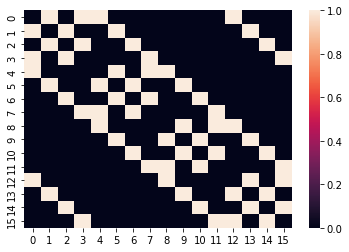

In [24]:
t = 1
U = 2
isPBC = True  # periodic boundary conditions


# H_kinetic = np.zeros((L, L), dtype=np.float32)
# above_diag = np.diag(t * np.ones(L**2 - 1), k=1)
# below_diag = np.diag(np.conj(t) * np.ones(L**2 - 1), k=-1)
# H_kinetic = above_diag + below_diag #+ np.diag(t * np.ones(L**2 - L-3), k=L+3) + np.diag(t * np.ones(L**2 - L), k=-L)

H_kinetic = np.zeros((L**2, L**2), dtype=np.float32)
numbering = np.arange(L**2).reshape(L, L)
for x in range(L):
    for y in range(L):
        i = numbering[x, y] # i = x * L + y, 
        j = numbering[x, y-1] # left
        H_kinetic[i,j] = t
        H_kinetic[j,i] = t
        j = numbering[x-1, y] # up
        H_kinetic[i,j] = t
        H_kinetic[j,i] = t

# if isPBC:
#     H_kinetic[0, -1] = np.conj(t)
#     H_kinetic[-1, 0] = t

sns.heatmap(H_kinetic)

numbering

-1.8345753694327105


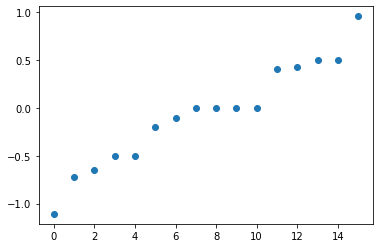

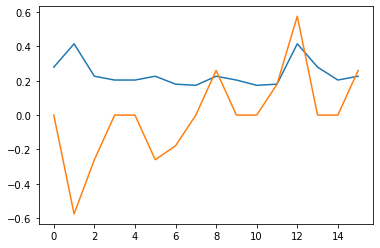

In [4]:


H = -H_kinetic - np.diag(U * lattice)

w, v = np.linalg.eigh(H)

energy = np.sum(w[:Ne]) / L
print(energy)

plt.scatter(range(L**2), w / L)
plt.show()

# sns.heatmap(np.transpose(v[:, :Ne]))
# plt.show()

plt.plot(v[:, :Ne])
plt.show()

testy gym

In [5]:
from gym import spaces

In [6]:
obs_space = spaces.MultiBinary(L)
tmp = obs_space.sample()

pos = rng.choice(L, size=Ne, replace=False)

lattice = np.full(L, False)
lattice[pos] = True

# gym

In [5]:
import gym
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from datetime import datetime
from gym.wrappers import TimeLimit


from sb3_contrib import MaskablePPO

# from sb3_contrib.common.envs import InvalidActionEnvDiscrete
from sb3_contrib.common.maskable.evaluation import evaluate_policy
from sb3_contrib.common.maskable.utils import get_action_masks

## CustomCNN

In [35]:
# class CustomCNN(BaseFeaturesExtractor):
#     """
#     :param observation_space: (gym.Space)
#     :param features_dim: (int) Number of features extracted.
#         This corresponds to the number of unit for the last layer.
#     """

#     def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
#         super(CustomCNN, self).__init__(observation_space, features_dim)
#         # Re-ordering will be done by pre-preprocessing or wrapper
#         self.cnn = nn.Sequential( # 1 input channel
#             nn.Conv1d(1, 8, kernel_size=3, padding=0), # 8 possible combinations
#             nn.BatchNorm1d(8),
#             nn.ReLU(),
#             nn.Conv1d(8, 32, kernel_size=3, stride=1, padding=0),
#             nn.BatchNorm1d(32),
#             nn.ReLU(),
#             nn.Flatten(),
#         )

#         # Compute shape by doing one forward pass
#         with torch.no_grad():
#             #! code repetition
#             n_flatten = self.cnn(
#                 F.pad(
#                     torch.as_tensor(observation_space.sample()[None])
#                     .unsqueeze(-2)
#                     .float(),
#                     pad=(1, 1),
#                     mode="circular",
#                 )
#             ).shape[1]

#         self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

#     def forward(self, observations: torch.Tensor) -> torch.Tensor:
#         # circular boundry conditions and add channel dimmension
#         return self.linear(
#             self.cnn(F.pad(observations.unsqueeze(-2), pad=(1, 1), mode="circular"))
#         )


# policy_kwargs = dict(
#     features_extractor_class=CustomCNN,
#     features_extractor_kwargs=dict(features_dim=128),
# )

In [22]:
side_length = 6
env = gym.make(
    "gym_xymodel:falicovkimball2D-v0",
    L=side_length,
    Ne=side_length**2 // 2,
    max_steps=side_length**2 // 2,
)
# env = TimeLimit(env, max_episode_steps=100)
from stable_baselines3.common.env_checker import check_env

check_env(env)
# env = gym.make('CartPole-v1')
# env.observation_space.shape
# env.action_space.n

env.state

array([ True, False,  True, False, False, False,  True, False,  True,
        True, False,  True,  True, False, False, False, False,  True,
        True, False,  True, False, False,  True,  True, False,  True,
       False, False,  True, False,  True,  True,  True,  True, False])

## PPO

In [ ]:
date = datetime.now().strftime("%Y-%m-%dT%H%M%S")
folder_path = f"../results/falicovkimball2D/{date}_L{side_length}"
# model = PPO("MlpPolicy", env, tensorboard_log=folder_path)
model = PPO("MlpPolicy", env, tensorboard_log=folder_path, verbose=1)
model.learn(60000)
model.save(f"{folder_path}/model")

### PPO with CNN

In [ ]:
# PPO with CNN
date = datetime.now().strftime("%Y-%m-%dT%H%M%S")
folder_path = f"../results/falicovkimball2D/{date}_L{side_length}_CNN"
# model = PPO("MlpPolicy", env, tensorboard_log=folder_path)
model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, tensorboard_log=folder_path, verbose=1)
model.learn(60000)
model.save(f"{folder_path}/model")

## MaskablePPO

In [23]:
date = datetime.now().strftime("%Y-%m-%dT%H%M%S")
folder_path = f"../results/falicovkimball2D/{date}_L{side_length}_mask"
# model = PPO("MlpPolicy", env, tensorboard_log=folder_path)
model = MaskablePPO("MlpPolicy", env,  tensorboard_log=folder_path, verbose=1)
model.learn(200_000)
# evaluate_policy(model, env, n_eval_episodes=20, reward_threshold=90, warn=False)
model.save(f"{folder_path}/model")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ../results/falicovkimball2D/2022-10-27T160303_L6_mask/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.3     |
|    ep_rew_mean     | 1.43     |
| time/              |          |
|    fps             | 87       |
|    iterations      | 1        |
|    time_elapsed    | 23       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 1.43        |
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 2           |
|    time_elapsed         | 43          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012690089 |
|    clip_fraction        | 0.132

## Maskable PPO - CNN

In [66]:
date = datetime.now().strftime("%Y-%m-%dT%H%M%S")
folder_path = f"../results/falicovkimball2D/{date}_L{side_length}_mask_CNN"
# model = PPO("MlpPolicy", env, tensorboard_log=folder_path)
model = MaskablePPO("CnnPolicy", env, policy_kwargs=policy_kwargs, tensorboard_log=folder_path, verbose=1)
model.learn(300_000)
# evaluate_policy(model, env, n_eval_episodes=20, reward_threshold=90, warn=False)
model.save(f"{folder_path}/model")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ../results/falicovkimball1D/2022-10-25T105602_L32_maskable_CNN/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | 1.26     |
| time/              |          |
|    fps             | 67       |
|    iterations      | 1        |
|    time_elapsed    | 30       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.88        |
|    ep_rew_mean          | 1.26        |
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 2           |
|    time_elapsed         | 97          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018586252 |
|    clip_fraction     

In [10]:
model.learn(200_000)
# evaluate_policy(model, env, n_eval_episodes=20, reward_threshold=90, warn=False)
model.save(f"{folder_path}/model")
model.policy

Logging to ../results/falicovkimball2D/2022-10-27T151036_L5_mask/PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7        |
|    ep_rew_mean     | 1.43     |
| time/              |          |
|    fps             | 132      |
|    iterations      | 1        |
|    time_elapsed    | 15       |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7          |
|    ep_rew_mean          | 1.44       |
| time/                   |            |
|    fps                  | 154        |
|    iterations           | 2          |
|    time_elapsed         | 26         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01275656 |
|    clip_fraction        | 0.129      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.66      |
|    explained_

MaskableActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential()
    (policy_net): Sequential(
      (0): Linear(in_features=25, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=25, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=52, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)

## Test env

[False False  True  True False False False  True  True  True False False
 False  True  True False False False False  True False False  True  True
 False False  True  True False  True  True  True False  True  True  True]
action=array([30,  4,  0])
[False False  True  True  True False False  True  True  True False False
 False  True  True False False False False  True False False  True  True
 False False  True  True False  True False  True False  True  True  True]
action=array([ 8, 24,  0])
[False False  True  True  True False False  True False  True False False
 False  True  True False False False False  True False False  True  True
  True False  True  True False  True False  True False  True  True  True]
action=array([29,  0,  0])
[ True False  True  True  True False False  True False  True False False
 False  True  True False False False False  True False False  True  True
  True False  True  True False False False  True False  True  True  True]
action=array([13, 21,  0])
[ True False

-1.4878427560273342

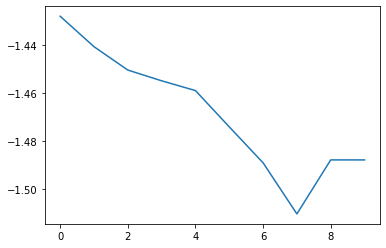

In [32]:
energies = []
obs = env.reset()
for i in range(20):
    print(env.state)
    action_masks = get_action_masks(env)
    action, _state = model.predict(obs, action_masks=action_masks, deterministic=True)
    print(f"{action=}")
    obs, reward, done, info = env.step(action)
    energies.append(env.compute_energy())
    if done:
        print(f"{reward=}")
        print(env.state)
        break
        # env.reset()
    # if i % 100 == 0:
    #   print(f"{i=}, {reward=}")
    #   env.render()

plt.plot(energies)
energies[-1]

In [26]:
evaluate_policy(model, env, n_eval_episodes=100, reward_threshold=1.3, warn=False)


(1.495185534954071, 0.01364361384888969)